In [1]:
#In this notebook we explore different weight optimization strategies
#sgd, momentum, adagrad, adam etc

#the data setting is taken from the Introduction chapter 1 of Bishop's Pattern Recognition and Machine Learning 

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
#for monitoring
from time import time
#for parsing the data filename
import re

In [348]:
np.random.seed(1)
N = 100

#We create some dat with some random noise added to a sin funtion
def get_noisy_data(N=100) :
    #we create some data from 0 to 1
    x = np.linspace(0,1,N)
    #will add some noise
    noise = np.random.normal(0,0.3,N)

    #this is the data + noise
    #y = sin(2pi a)
    t = noise + np.sin(2*np.pi*x)
    return x, t

#sin(2pi x)
def get_clean_data(N=100) :
    x = np.linspace(0,1,N)
    y = np.sin(2*np.pi*x)
    return x, y

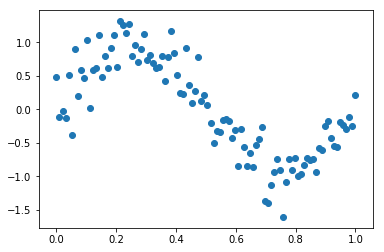

In [349]:
x, t = get_noisy_data()
plt.scatter(x, t)

In [5]:
#polynomial funtion
def pol(xi, w) : #xi is single value and w is a vector of weights.
    s = 0.0
    for i in range(len(w)) :
        s += w[i] * np.power(xi, i)
    return s

def error(f, x, t ) : #
    return 0.5 * np.sum( ( f(x)-t )**2 )

def rms_error(f,x,t) : #root mean squared error
    return np.sqrt( 2.0* error(f,x,t)/len(x))

In [423]:
#w = [0.31, 7.99, -25.43, 17.37]
f = lambda x: pol(x,w)
#np.sqrt( 2.0 * error( f, x, t)/len(x) )

In [9]:
#rms_error(lambda x: pol(x,w),x,t)

In [426]:
#this is a crude optimization. Just perturb the weights randomly and take if it is improving loss
def optim1( a, t, w, K=10000 ) : #K iterations
    prev = 1000
    for _ in range(K) :
        delta = np.random.normal(0,0.1,len(w))
        for i,d in enumerate(delta) :
            w[i] += d
            f = lambda x: pol(x,w)
            e = rms_error( f, a, t) 
            if e > prev : #more error; we dont want this change
                w[i] -= d
            else : #new low error
                prev = e
    return w, prev


In [427]:
np.random.seed(40)
w = np.random.normal(0,0.01,9) * 0.01
w,p = optim1( x,t,w)
rms_error(f,x,t)

0.2965823614125529

In [428]:
#test_error
x_test, y_test = get_noisy_data() #get some fresh data
rms_error(f, x_test, y_test)

0.3414284336889782

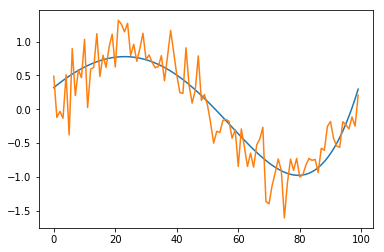

In [429]:
p = pol(x, w)
plt.plot(p)
plt.plot(t)

In [15]:
#we need this for the grad funtion
import autograd.numpy as np
from autograd import grad

In [431]:
#we create a new funtion with just w as input
e = lambda w: rms_error(lambda x: pol(x,w), x, t )

#and its grad function
grad_e = grad( e )

In [432]:
e(w)

0.2965823614125529

In [433]:
delta = grad_e(w)
delta

array([ 0.01808386,  0.00318633,  0.0064618 ,  0.00347655,  0.00076433,
       -0.00045792, -0.00045813,  0.0003176 ,  0.00151969])

In [435]:
#Now we create all the update rules
class sgd :
    def __init__(self, learning_rate ) :
        self.learning_rate = learning_rate
        
    def update(self, w, delta) :
        new_w = w + -1 * self.learning_rate*delta
        return new_w

class momentum :
    def __init__(self, learning_rate, momentum ) :
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.v = None
        
    def update(self, w, delta) :
        if self.v is None :
            self.v = np.empty_like(w)
        
        self.v = self.v * self.momentum - self.learning_rate * delta        
        new_w = w + self.v
        
        return new_w
    
    
    
class adagrad :
    def __init__(self, learning_rate) :
        self.learning_rate = learning_rate
        self.eps = 1e-8 #for neumerical stability
        self.cache = None
    
    def update(self, w, delta) :
        if self.cache is None :
            self.cache = delta**2
        else :        
            self.cache += delta**2
        
        new_w = w + -1 * self.learning_rate*delta / (np.sqrt(self.cache) + self.eps)
        return new_w

class rmsprop :
    def __init__(self, learning_rate, decay_rate ) :
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.eps = 1e-8 #for neumerical stability
        self.cache = None
    
    def update(self, w, delta) :
        if self.cache is None :
            self.cache = (delta**2)
        else :        
            self.cache = self.decay_rate*self.cache + (1-self.decay_rate)*(delta**2)
        
        new_w = w + -1 * self.learning_rate*delta / (np.sqrt(self.cache) + self.eps)
        return new_w
    
class adam :
    def __init__(self, learning_rate, beta1=0.9, beta2=0.99 ) :
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = 1e-8 #for neumerical stability
        self.cache = None
        self.v = None
        
    
    def update(self, w, delta) :
        if self.cache is None :
            self.cache = (delta**2)
            self.m = (1-self.beta1)*delta
        else :        
            self.cache = self.beta2*self.cache + (1-self.beta2)*(delta**2)
            self.m = self.beta1*self.m + (1-self.beta1)*delta
        
        value = -1*self.learning_rate*self.m
        scale = (np.sqrt(self.cache) + self.eps)
        
        new_w = w + value / scale
        return new_w

In [436]:
def optimize(rule, w, K=1000) :
    loss = []
    for _ in range(K) :
        g = e(w)
        loss.append(g)
        delta = grad_e(w)
        w = rule.update(w, delta)
    return w, np.array(loss)

In [417]:
np.random.seed(40)
w = np.random.normal(0,0.01,9) * 0.01
e = lambda w: rms_error(lambda x: pol(x,w), x, t )
grad_e = grad( e )

In [418]:
rule = sgd(0.1)
rule = momentum( 0.6, 0.9)
#rule = adagrad( 0.9 )
#rule = rmsprop( 0.6, 0.99 )
#rule = adam( 0.6 )

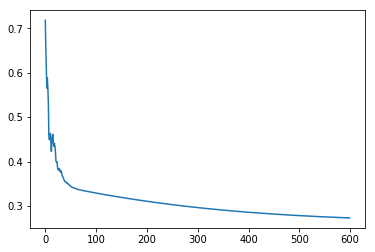

In [419]:
w,loss = optimize(rule, w, 600)
plt.plot(loss)

In [420]:
#rule = adam( 0.6 )

In [421]:

for K in [200] : #, 1000 1000, 10000, 10000, 10000 ] :
    w_store = []
    loss = []
    for i in range(K) :
        #if (i % 100) == 0 :
        #    rule = momentum( 0.6, 0.99)
        g = e(w)
        loss.append(g)
        delta = grad_e(w)
        #rule.update(w, delta)
        w = rule.update(w, delta)
        w_store.append(w.copy())
    print( loss[0], loss[-1])

0.2727835257863756 0.2753700696553839


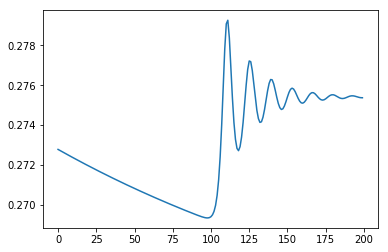

In [422]:
plt.plot(loss)

In [388]:
w_store = np.array(w_store)

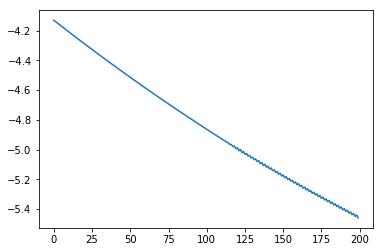

In [410]:
plt.plot(w_store[:,8])

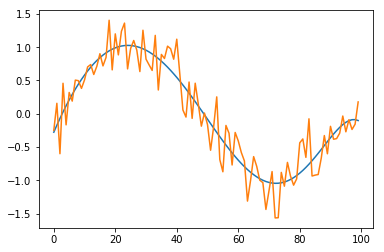

In [71]:
p = pol(x, w)
plt.plot(p)
plt.plot(t)

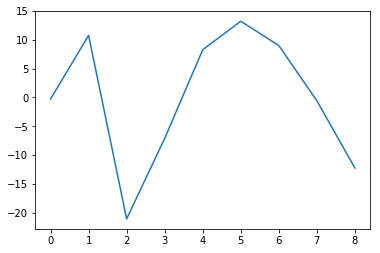

In [67]:
plt.plot(w)

0.2961093204404074


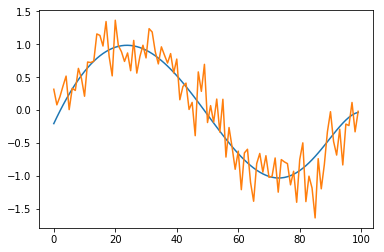

In [310]:
x_test, y_test = get_noisy_data() #get some fresh data
print( rms_error(lambda x: pol(x,w), x_test, y_test) )
p = pol(x_test, w)
plt.plot(p)
plt.plot(y_test)

0.16534184035381527


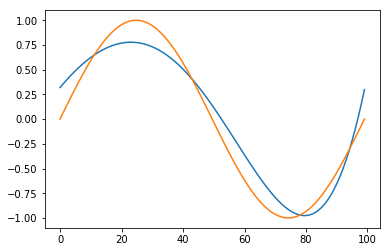

In [430]:
x_test, y_test = get_clean_data() #get some fresh data
print( rms_error(lambda x: pol(x,w), x_test, y_test) )
p = pol(x_test, w)
plt.plot(p)
plt.plot(y_test)

In [158]:
np.random.seed(41)
w = np.random.normal(-1,0.01,9) * 0.01
e = lambda w: rms_error(lambda x: pol(x,w), x, t )
grad_e = grad( e )

In [159]:

ada = adagrad( 0.9 )
sg = sgd(0.2)
mom = momentum( 0.4, 0.9)
rms = rmsprop( 0.6, 0.99 )
adm = adam(0.6)

0.06448384534157134
0.0607233897807396


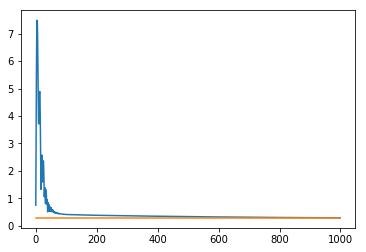

In [160]:
for rule in [mom, sg ] :
    w, l = optimize(rule, w, 1000 )
    plt.plot(l)
    x_test, y_test = get_clean_data() #get some fresh data
    print( rms_error(lambda x: pol(x,w), x_test, y_test) )